# Baseline Solution for Predicting Covid Global Forcast
<p><c>
    <img src="images/corona.png" alt="corona" width=200/>
</c></p>

글로벌 코로나 바이러스의 누적 확잔수와 사망자수의 예측 문제를 featuretools를 이용해서 풀어보기로 한다. 본 노트북에서는 기존 feature들로만 random forest 학습을 할 때의 baseline 성능을 측정한다. 

In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from featuretools.primitives import Count, Mean
import utils
import os
%matplotlib inline

보다시피 최소한의 feature manipulation을 할 만한 원천 feature가 너무 없다 

In [2]:
data = pd.read_csv('data/train.csv', parse_dates=['Date'], encoding='utf-8')
data.rename(columns={'Date': 'date', 
                     'Province/State':'state', 'Lat': 'lat', 'Long': 'long',
                     'Country/Region':'country',
                     'ConfirmedCases': 'confirmed',
                     'Fatalities':'deaths'
                    }, inplace=True)
data[data['country']=='China'].head(5)

,Id,state,country,lat,long,date,confirmed,deaths
2961,4372,Anhui,China,31.8257,117.2264,2020-01-22,1.0,0.0
2962,4373,Anhui,China,31.8257,117.2264,2020-01-23,9.0,0.0
2963,4374,Anhui,China,31.8257,117.2264,2020-01-24,15.0,0.0
2964,4375,Anhui,China,31.8257,117.2264,2020-01-25,39.0,0.0
2965,4376,Anhui,China,31.8257,117.2264,2020-01-26,60.0,0.0


# 나라 통계 정보와 결합 

In [3]:
countries_df = utils.get_country_df()
countries_df.head()

,country,population,density,fertility,age,urban_percentage
0,China,1439323776,153,1.7,38.0,0.61
1,India,1380004385,464,2.2,28.0,0.35
2,US,331002651,36,1.8,38.0,0.83
3,Indonesia,273523615,151,2.3,30.0,0.56
4,Pakistan,220892340,287,3.6,23.0,0.35


In [4]:
data = pd.merge(data, countries_df, on='country')
data[data['country']=='China'].head(5)

,Id,state,country,lat,long,date,confirmed,deaths,population,density,fertility,age,urban_percentage
2961,4372,Anhui,China,31.8257,117.2264,2020-01-22,1.0,0.0,1439323776,153,1.7,38.0,0.61
2962,4373,Anhui,China,31.8257,117.2264,2020-01-23,9.0,0.0,1439323776,153,1.7,38.0,0.61
2963,4374,Anhui,China,31.8257,117.2264,2020-01-24,15.0,0.0,1439323776,153,1.7,38.0,0.61
2964,4375,Anhui,China,31.8257,117.2264,2020-01-25,39.0,0.0,1439323776,153,1.7,38.0,0.61
2965,4376,Anhui,China,31.8257,117.2264,2020-01-26,60.0,0.0,1439323776,153,1.7,38.0,0.61


# Weather 정보와 결합

In [5]:
weather_df = utils.get_weather_df()
weather_df.head(5)

,index,country,state,date,humidity,sunHour,tempC,windspeedKmph
0,0,Afghanistan,,2020-01-22,65.0,8.7,-1.0,8.0
1,1,Afghanistan,,2020-01-23,59.0,8.7,-3.0,8.0
2,2,Afghanistan,,2020-01-24,71.0,7.1,0.0,7.0
3,3,Afghanistan,,2020-01-25,79.0,8.7,0.0,7.0
4,4,Afghanistan,,2020-01-26,64.0,8.7,-1.0,8.0


In [6]:
data = data.merge(weather_df, on=['country','date', 'state'], how='inner')
data[data['country']=='China'].head(5)

,Id,state,country,lat,long,date,confirmed,deaths,population,density,fertility,age,urban_percentage,index,humidity,sunHour,tempC,windspeedKmph
1200,4372,Anhui,China,31.8257,117.2264,2020-01-22,1.0,0.0,1439323776,153,1.7,38.0,0.61,2820,36.0,8.7,7.0,4.0
1201,4373,Anhui,China,31.8257,117.2264,2020-01-23,9.0,0.0,1439323776,153,1.7,38.0,0.61,2853,44.0,8.7,7.0,7.0
1202,4374,Anhui,China,31.8257,117.2264,2020-01-24,15.0,0.0,1439323776,153,1.7,38.0,0.61,2886,42.0,8.7,3.0,4.0
1203,4375,Anhui,China,31.8257,117.2264,2020-01-25,39.0,0.0,1439323776,153,1.7,38.0,0.61,2919,47.0,8.7,7.0,4.0
1204,4376,Anhui,China,31.8257,117.2264,2020-01-26,60.0,0.0,1439323776,153,1.7,38.0,0.61,2952,46.0,8.7,3.0,4.0


# 천명당 병상수 정보와 결합 

In [7]:
icu_df = utils.get_icu_df()
icu_df.head(5)

,country,icu
0,Aruba,NaN
1,Afghanistan,0.5
2,Angola,0.8
3,Albania,2.9
4,Andorra,2.5


In [8]:
data = pd.merge(data, icu_df, on='country')
data[data['country']=='China'].head(5)

,Id,state,country,lat,long,date,confirmed,deaths,population,density,fertility,age,urban_percentage,index,humidity,sunHour,tempC,windspeedKmph,icu
1200,4372,Anhui,China,31.8257,117.2264,2020-01-22,1.0,0.0,1439323776,153,1.7,38.0,0.61,2820,36.0,8.7,7.0,4.0,4.2
1201,4373,Anhui,China,31.8257,117.2264,2020-01-23,9.0,0.0,1439323776,153,1.7,38.0,0.61,2853,44.0,8.7,7.0,7.0,4.2
1202,4374,Anhui,China,31.8257,117.2264,2020-01-24,15.0,0.0,1439323776,153,1.7,38.0,0.61,2886,42.0,8.7,3.0,4.0,4.2
1203,4375,Anhui,China,31.8257,117.2264,2020-01-25,39.0,0.0,1439323776,153,1.7,38.0,0.61,2919,47.0,8.7,7.0,4.0,4.2
1204,4376,Anhui,China,31.8257,117.2264,2020-01-26,60.0,0.0,1439323776,153,1.7,38.0,0.61,2952,46.0,8.7,3.0,4.0,4.2


# Make Train data

* 감염률이 0보다 큰 것만 고려

In [9]:
def make_feature_label(data):     
    train_data = data.copy()
    #threshold = 0
    threshold = 0.00001
    train_data['infectionRate'] = round((train_data['confirmed']/train_data['population'])*100, 5)
    train_data = train_data[train_data['infectionRate'] >= threshold]
    train_data = train_data.drop([
                                 "country", 
                                 "infectionRate",
                                 "state",
                                 "lat",
                                 "long",
                                 "date",
                                 "index",
                                 "Id"
                                ], axis= 1).dropna()

    y = train_data[["confirmed", "deaths"]]
    X = train_data.drop(["confirmed", "deaths"],axis=1)
    return X, y

X, y = make_feature_label(data)
print(X.shape, y.shape)

(2299, 10) (2299, 2)


In [10]:
X.head(5)

,population,density,fertility,age,urban_percentage,humidity,sunHour,tempC,windspeedKmph,icu
54,25499884,3,1.8,38.0,0.86,73.0,11.6,20.0,12.0,3.8
55,25499884,3,1.8,38.0,0.86,66.0,11.6,24.0,4.0,3.8
56,25499884,3,1.8,38.0,0.86,62.0,11.6,24.0,7.0,3.8
57,25499884,3,1.8,38.0,0.86,55.0,11.6,27.0,6.0,3.8
58,25499884,3,1.8,38.0,0.86,49.0,11.6,27.0,18.0,3.8


# Train and Evaluate Model (Random Forest)

In [11]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error, make_scorer

# 평가 척도 함수 정의
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error of a prediction set.
    params:
        y_true: numpy array of ground truth
        y_pred: numpy array of predictions
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle)

# Split into training and evaluation data:
X_train, X_val, y_train, y_val = tts(X, y, test_size= 0.2, random_state=42, shuffle=True)


# 확진자수 예측 모델 학습/평가
model_infected = DecisionTreeRegressor(random_state=42, criterion="mae")
scores = cross_val_score(model_infected, X_train,y_train["confirmed"], cv=5, scoring=rmsle_scorer)

print("Cross Validation of Confirmed Cases: Mean = {}, std = {}".format(scores.mean(), scores.std()))
model_infected.fit(X_train, y_train["confirmed"])
result_infected = rmsle(y_val["confirmed"], model_infected.predict(X_val))
print("Validation Infected set RMSLE: {}".format(result_infected))

# 사망자수 예측 모델 학습/평가
model_deaths = DecisionTreeRegressor(random_state=42, criterion="mae")
scores = cross_val_score(model_deaths, X_train, y_train["deaths"], cv=5, scoring=rmsle_scorer)

print("Cross Validation of Fatal Cases: Mean = {}, std = {}".format(scores.mean(), scores.std()))
model_deaths.fit(X_train, y_train["deaths"])
result_deaths = rmsle(y_val["deaths"], model_deaths.predict(X_val))
print("Validation Death set RMSLE: {}".format(result_deaths))


# Final Evalutation
print("Final Validatio score: {}".format(np.mean([result_infected, result_deaths])))

Cross Validation of Confirmed Cases: Mean = 1.7065675703548764, std = 0.07405177394572382
Validation Infected set RMSLE: 1.6101617988466888
Cross Validation of Fatal Cases: Mean = 1.357374926844444, std = 0.11020961439972082
Validation Death set RMSLE: 1.3988534878600043
Final Validatio score: 1.5045076433533464


# 주요 feature 도식화 

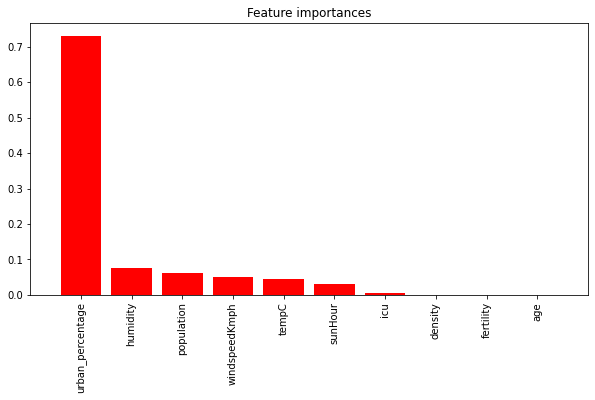

In [12]:
utils.show_feature_importance(X_train,model_infected)

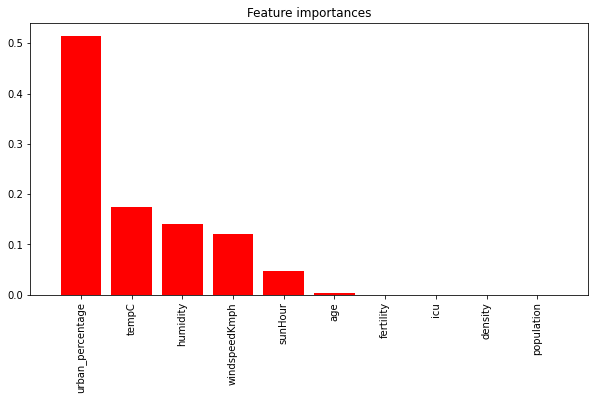

In [13]:
utils.show_feature_importance(X_train,model_deaths)